<a href="https://colab.research.google.com/github/fernandobatistti/Special-Topics-in-Applied-Physics---Project-II/blob/main/Code/Projeto_II_C%C3%B3digo_Fonte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTITUTO LATINO-AMERICANO DECIÊNCIAS DA VIDA E DA NATUREZA (ILACVN)**

Curso: Física Aplicada

Disciplina: FIS0006 - TÓPICOS ESPECIAIS EM FÍSICA EXPERIMENTAL

Professor JOYLAN NUNES MACIEL





**Projeto I: Classificação de dígitos manuscritos (MNIST)**



Estudante:
Fernando José Zardinello Batistti 	(2024101000016465)




Foz do Iguaçu, 06 de junho de 2025.



# Projeto II - Classificação de dígitos manuscritos (MNIST)


In [3]:
### 0. Bibliotecas que serão utilizadas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import os
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Instalar o Keras Tuner, que será usado na etapa 9
!pip install -q -U keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


## 1) Coleta de dados

Mounted at /content/drive
Dados carregados com sucesso!


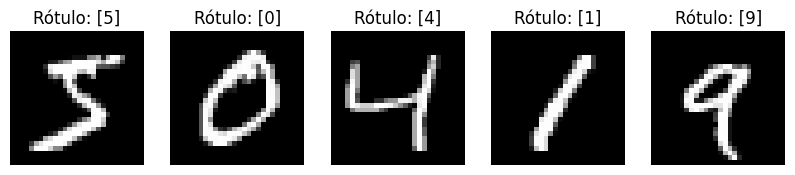

In [4]:
### 1. Coleta de Dados
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='latin1')
    return dict_data

qmnist = unpickle("/content/drive/MyDrive/Tópicos Especiais Em Física Experimental/Projeto MNIST/Dados/MNIST-120k")
data = qmnist['data']
labels = np.array(qmnist['labels'])

print("Dados carregados com sucesso!")
# Visualizar algumas imagens para confirmar
plt.figure(figsize=(10, 5))
for i in range(5):
    imagem = np.array(data[i]).reshape(28, 28)
    plt.subplot(1, 5, i + 1)
    plt.imshow(imagem, cmap='gray')
    plt.title(f'Rótulo: {labels[i]}')
    plt.axis('off')
plt.show()

## 2) Limpeza e pré-processamento de dados

In [5]:
### 2. Limpeza e Pré-processamento de Dados

# Verificar se há valores nulos (improvável para este dataset, mas é uma boa prática)
print(f"Valores nulos nos dados: {np.isnan(data).any()}")

# 1. Normalizar os dados de pixels para o intervalo [0, 1]
X = np.array(data) / 255.0

# 2. Remodelar os dados para o formato que a CNN espera: (amostras, altura, largura, canais)
X = X.reshape(-1, 28, 28, 1)

# 3. Manter os rótulos como inteiros por enquanto
y_inteiros = np.array(labels)

print("\nPré-processamento concluído.")
print(f"Formato dos dados (X): {X.shape}")
print(f"Formato dos rótulos (y_inteiros): {y_inteiros.shape}")

Valores nulos nos dados: False

Pré-processamento concluído.
Formato dos dados (X): (120000, 28, 28, 1)
Formato dos rótulos (y_inteiros): (120000, 1)


## 3) Análise Exploratória de Dados (EDA)

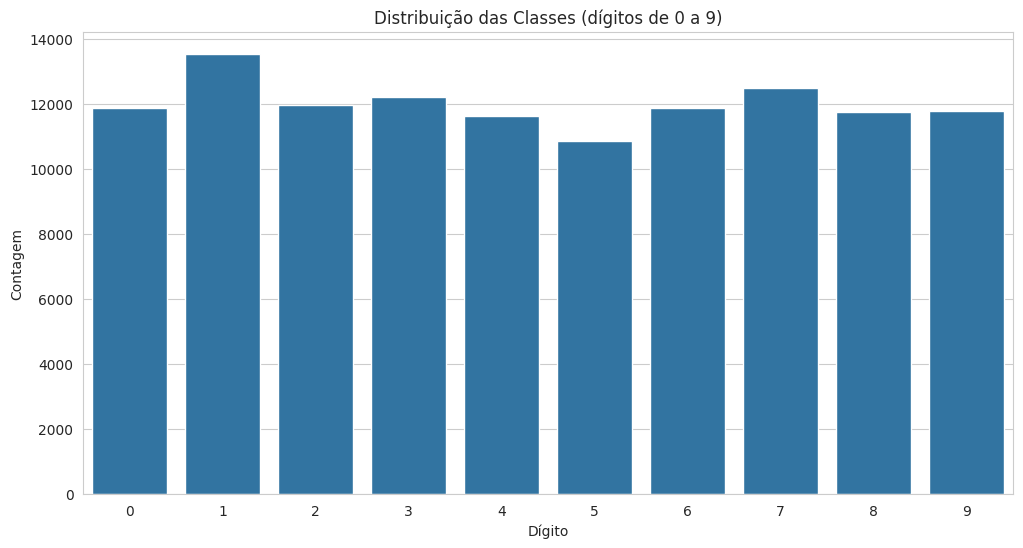

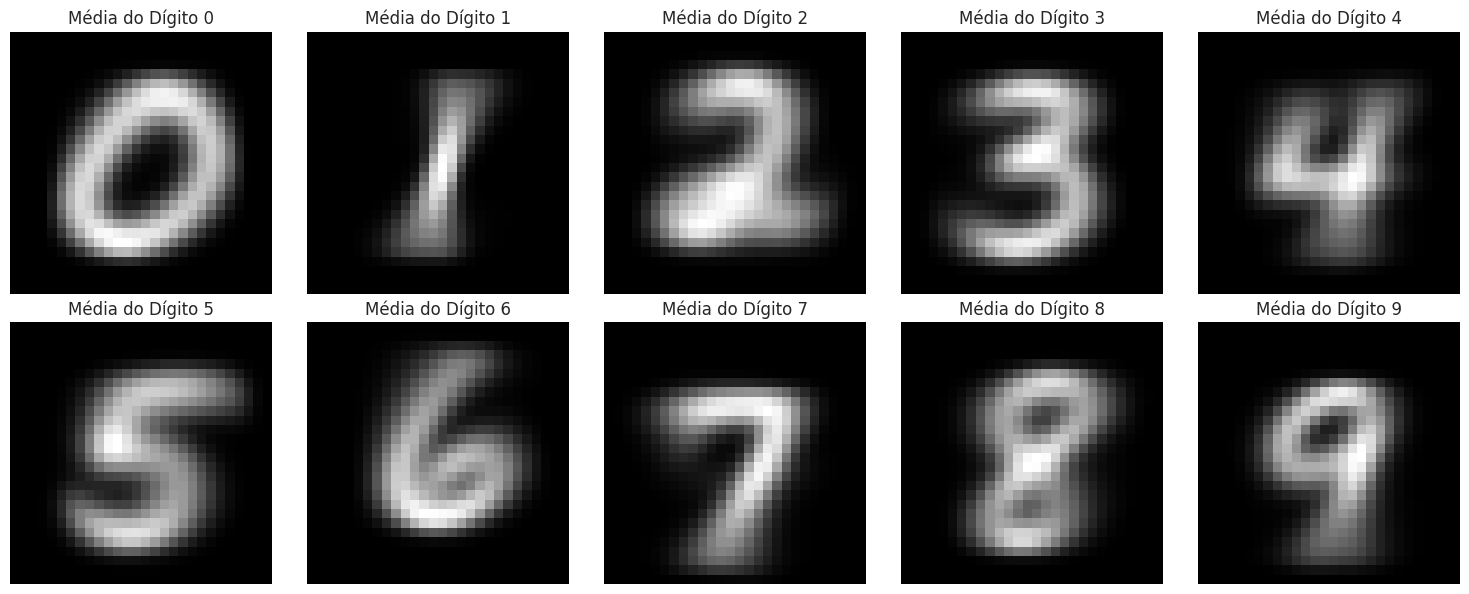

In [6]:
### 3. Análise Exploratória de Dados (EDA)

# Configurações de estilo para os gráficos
sns.set_style("whitegrid")

# 1. Verificar o balanceamento das classes
# Contar quantas amostras existem para cada dígito (0 a 9)
plt.figure(figsize=(12, 6))

# Usamos .flatten() para garantir que o array seja unidimensional
sns.countplot(x=y_inteiros.flatten())
# -----------------------------

plt.title('Distribuição das Classes (dígitos de 0 a 9)')
plt.xlabel('Dígito')
plt.ylabel('Contagem')
plt.show()

# 2. Visualizar a "imagem média" para cada dígito
# Esta parte do código já deve funcionar corretamente, pois não depende da dimensão do y_inteiros da mesma forma.
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    # Filtrar os dados para o dígito atual
    # O .flatten() aqui também ajuda a garantir que a comparação booleana funcione corretamente
    imagens_do_digito = X[y_inteiros.flatten() == i]
    # Calcular a média de todos os pixels
    imagem_media = np.mean(imagens_do_digito, axis=0)
    # Exibir a imagem média
    axes[i].imshow(imagem_media.reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Média do Dígito {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 4) Engenharia de Características (*Feature Engineering*)

Engenharia de Características (Feature Engineering):

Aqui, justificamos por que esta etapa é diferente para Redes Neurais Convolucionais (CNNs).

Justificativa:
Para modelos de Machine Learning clássicos, a engenharia de características é uma etapa manual e crucial onde o cientista de dados cria novas features para ajudar o modelo a aprender.
No caso de Deep Learning com CNNs, a principal vantagem é que a rede neural realiza a engenharia de características automaticamente. As camadas convolucionais (Conv2D) são projetadas especificamente para aprender a extrair features relevantes diretamente dos pixels brutos. Elas aprendem a identificar bordas, texturas, formas e, em camadas mais profundas, partes de objetos (como o laço de um '8' ou a haste de um '7').
Portanto, para este projeto, não há uma etapa de engenharia de características manual. O pré-processamento (normalização e remodelação) que fizemos na etapa 2 é suficiente para preparar os dados para a CNN.

## 5) Divisão do dataset (treinamento e teste)

In [7]:
### 5. Divisão do Dataset

num_classes = len(np.unique(y_inteiros))

# Dividir os dados
X_treino, X_teste, y_treino_int, y_teste_int = train_test_split(
    X, y_inteiros,
    test_size=0.2,
    random_state=42,
    stratify=y_inteiros
)

# Converter rótulos para one-hot encoding
y_treino = to_categorical(y_treino_int, num_classes=num_classes)
y_teste = to_categorical(y_teste_int, num_classes=num_classes)

print("Dimensões dos conjuntos:")
print("X_treino:", X_treino.shape, "| y_treino:", y_treino.shape)
print("X_teste:", X_teste.shape, "| y_teste:", y_teste.shape)

Dimensões dos conjuntos:
X_treino: (96000, 28, 28, 1) | y_treino: (96000, 10)
X_teste: (24000, 28, 28, 1) | y_teste: (24000, 10)


## 6) Escolha do Modelo

===== Fold 1/3 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 86s 41ms/step - accuracy: 0.8546 - loss: 0.4514 - val_accuracy: 0.9806 - val_loss: 0.0604
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 129s 35ms/step - accuracy: 0.9735 - loss: 0.0898 - val_accuracy: 0.9844 - val_loss: 0.0500
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.9810 - loss: 0.0630 - val_accuracy: 0.9879 - val_loss: 0.0377
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 90s 39ms/step - accuracy: 0.9835 - loss: 0.0531 - val_accuracy: 0.9890 - val_loss: 0.0347
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 77s 36ms/step - accuracy: 0.9888 - loss: 0.0384 - val_accuracy: 0.9891 - val_loss: 0.0337
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 78s 34ms/step - accuracy: 0.9888 - loss: 0.0373 - val_accuracy: 0.9875 - val_loss: 0.0426
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9898 - loss: 0.0325 - val_accuracy: 0.9899 - val_loss: 0.0352
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.9913 

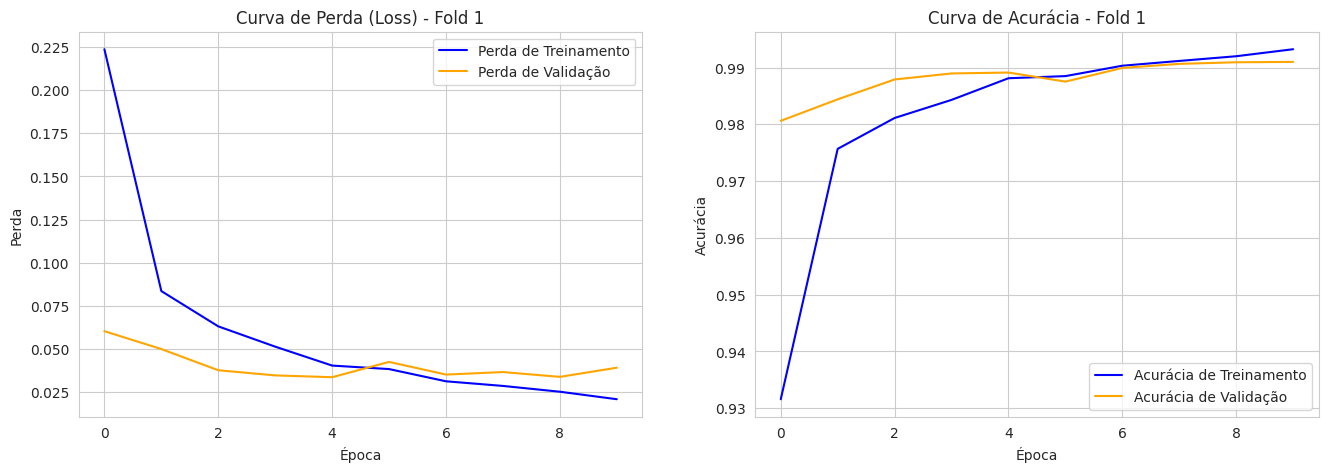

===== Fold 2/3 =====
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - accuracy: 0.8597 - loss: 0.4349 - val_accuracy: 0.9799 - val_loss: 0.0646
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.9737 - loss: 0.0905 - val_accuracy: 0.9866 - val_loss: 0.0427
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9800 - loss: 0.0667 - val_accuracy: 0.9881 - val_loss: 0.0425
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9842 - loss: 0.0527 - val_accuracy: 0.9897 - val_loss: 0.0357
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9874 - loss: 0.0406 - val_accuracy: 0.9900 - val_loss: 0.0333
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - accuracy: 0.9897 - loss: 0.0341 - val_accuracy: 0.9907 - val_loss: 0.0346
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9908 - loss: 0.0313 - val_accuracy: 0.9914 - val_loss: 0.0333
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step

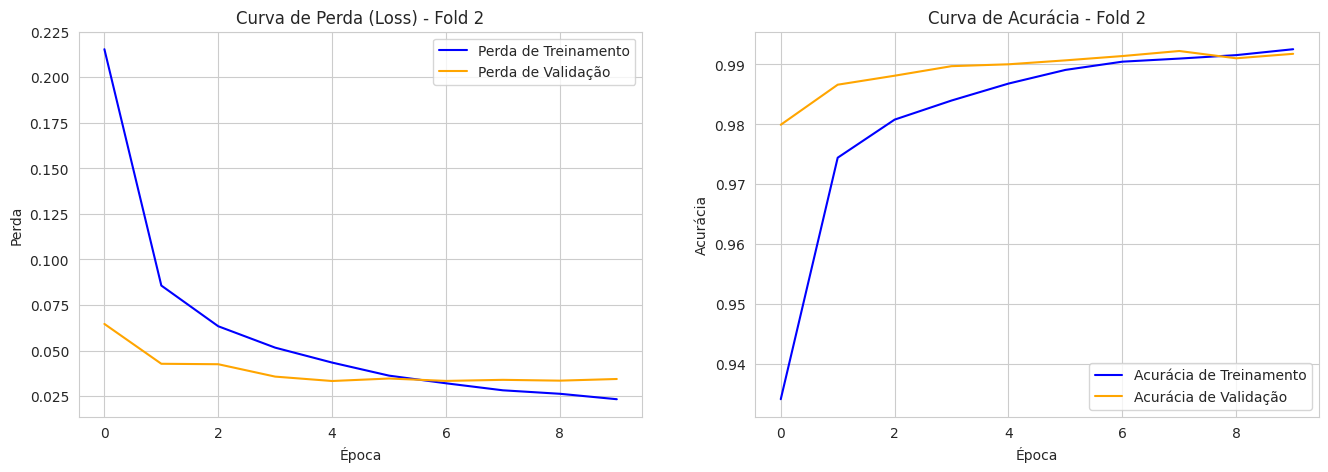

===== Fold 3/3 =====
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 75s 36ms/step - accuracy: 0.8659 - loss: 0.4214 - val_accuracy: 0.9838 - val_loss: 0.0526
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - accuracy: 0.9751 - loss: 0.0830 - val_accuracy: 0.9880 - val_loss: 0.0391
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9811 - loss: 0.0636 - val_accuracy: 0.9893 - val_loss: 0.0355
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.9858 - loss: 0.0488 - val_accuracy: 0.9901 - val_loss: 0.0331
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.9872 - loss: 0.0419 - val_accuracy: 0.9908 - val_loss: 0.0320
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.9899 - loss: 0.0337 - val_accuracy: 0.9913 - val_loss: 0.0323
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - accuracy: 0.9907 - loss: 0.0311 - val_accuracy: 0.9919 - val_loss: 0.0288
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step

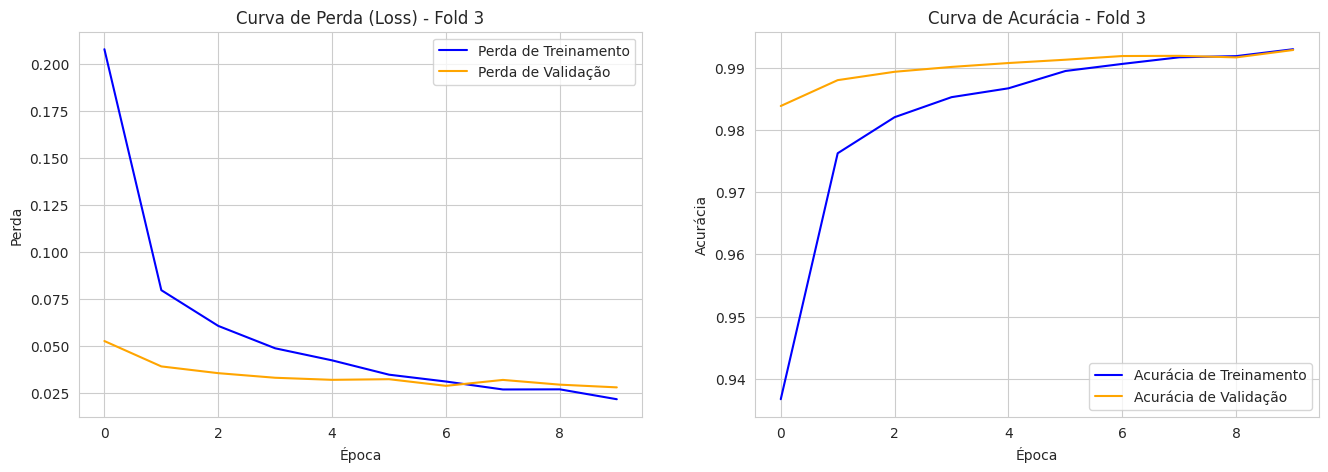


===== Resultados Finais da Validação Cruzada =====
Pontuações de acurácia por fold: ['0.9910', '0.9918', '0.9928']
Acurácia média: 0.9919 (+/- 0.0008)


In [8]:
### 6. Escolha do modelo (com Validação Cruzada e Gráficos)

# Definir o número de folds para a validação cruzada
n_splits = 3 # Usar 3 folds é um bom começo. Ajuste se necessário.

# Configurar o StratifiedKFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Listas para armazenar as pontuações e históricos
pontuacoes_acuracia = []
historicos_treinamento = []

# Loop sobre os folds usando o conjunto de TREINO
for fold, (indices_treino_fold, indices_validacao_fold) in enumerate(kf.split(X_treino, y_treino_int)):
    print(f"===== Fold {fold + 1}/{n_splits} =====")

    X_treino_kfold, X_validacao_kfold = X_treino[indices_treino_fold], X_treino[indices_validacao_fold]
    y_treino_kfold, y_validacao_kfold = y_treino[indices_treino_fold], y_treino[indices_validacao_fold]

    # Construir um NOVO modelo CNN para cada fold
    modelo_fold = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    modelo_fold.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

    # Treinar o modelo no fold atual
    historico_fold = modelo_fold.fit(X_treino_kfold, y_treino_kfold,
                                     epochs=10,
                                     batch_size=32,
                                     validation_data=(X_validacao_kfold, y_validacao_kfold),
                                     verbose=1)

    # Avaliar e armazenar os resultados do fold
    perda_fold, acuracia_fold = modelo_fold.evaluate(X_validacao_kfold, y_validacao_kfold, verbose=0)
    print(f"\nAcurácia de Validação do Fold {fold + 1}: {acuracia_fold:.4f}")
    pontuacoes_acuracia.append(acuracia_fold)
    historicos_treinamento.append(historico_fold)

    # Plotando as curvas de aprendizado para o fold atual
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # --- Gráfico da Perda (Loss) ---
    ax[0].plot(historico_fold.history['loss'], label='Perda de Treinamento', color='blue')
    ax[0].plot(historico_fold.history['val_loss'], label='Perda de Validação', color='orange')
    ax[0].set_title(f'Curva de Perda (Loss) - Fold {fold + 1}')
    ax[0].set_xlabel('Época')
    ax[0].set_ylabel('Perda')
    ax[0].legend()
    ax[0].grid(True)

    # --- Gráfico da Acurácia ---
    ax[1].plot(historico_fold.history['accuracy'], label='Acurácia de Treinamento', color='blue')
    ax[1].plot(historico_fold.history['val_accuracy'], label='Acurácia de Validação', color='orange')
    ax[1].set_title(f'Curva de Acurácia - Fold {fold + 1}')
    ax[1].set_xlabel('Época')
    ax[1].set_ylabel('Acurácia')
    ax[1].legend()
    ax[1].grid(True)

    plt.show()
    # ===============================================================================

# Exibir os resultados consolidados da validação cruzada
print("\n===== Resultados Finais da Validação Cruzada =====")
print(f"Pontuações de acurácia por fold: {[f'{acc:.4f}' for acc in pontuacoes_acuracia]}")
print(f"Acurácia média: {np.mean(pontuacoes_acuracia):.4f} (+/- {np.std(pontuacoes_acuracia):.4f})")

## 7) Implementação, treinamento (e validação, alguns modelos)

In [9]:
### 7. Implementação e Treinamento

print("--- Treinando o Modelo Final ---")

# Construir o modelo final com a arquitetura validada
modelo_final = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

modelo_final.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Treinar o modelo
historico_final = modelo_final.fit(X_treino, y_treino,
                                   epochs=15,
                                   batch_size=32,
                                   validation_data=(X_teste, y_teste), # Usando o teste para validação aqui
                                   verbose=1)

--- Treinando o Modelo Final ---
Epoch 1/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 102s 33ms/step - accuracy: 0.8755 - loss: 0.3989 - val_accuracy: 0.9839 - val_loss: 0.0531
Epoch 2/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 138s 32ms/step - accuracy: 0.9767 - loss: 0.0806 - val_accuracy: 0.9883 - val_loss: 0.0360
Epoch 3/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 146s 33ms/step - accuracy: 0.9835 - loss: 0.0585 - val_accuracy: 0.9889 - val_loss: 0.0380
Epoch 4/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 141s 33ms/step - accuracy: 0.9863 - loss: 0.0452 - val_accuracy: 0.9908 - val_loss: 0.0301
Epoch 5/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 138s 32ms/step - accuracy: 0.9876 - loss: 0.0397 - val_accuracy: 0.9891 - val_loss: 0.0382
Epoch 6/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 141s 31ms/step - accuracy: 0.9903 - loss: 0.0316 - val_accuracy: 0.9915 - val_loss: 0.0299
Epoch 7/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 93s 31ms/step - accuracy: 0.9908 - loss: 0.0289 - val_accuracy: 0.9916 - val_loss: 0.0279
Epoch 8/15
3000/3000 ━━━━━━━━━━━━━━━━

## 8) Avaliação com dados de teste


Acurácia Geral no Conjunto de Teste: 0.9920
Perda no Conjunto de Teste: 0.0408
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2375
           1       0.99      1.00      0.99      2707
           2       0.99      0.99      0.99      2397
           3       1.00      0.99      0.99      2443
           4       0.99      0.99      0.99      2324
           5       0.99      0.99      0.99      2175
           6       0.99      0.99      0.99      2375
           7       0.99      0.99      0.99      2499
           8       1.00      0.99      0.99      2348
           9       0.99      0.99      0.99      2357

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000



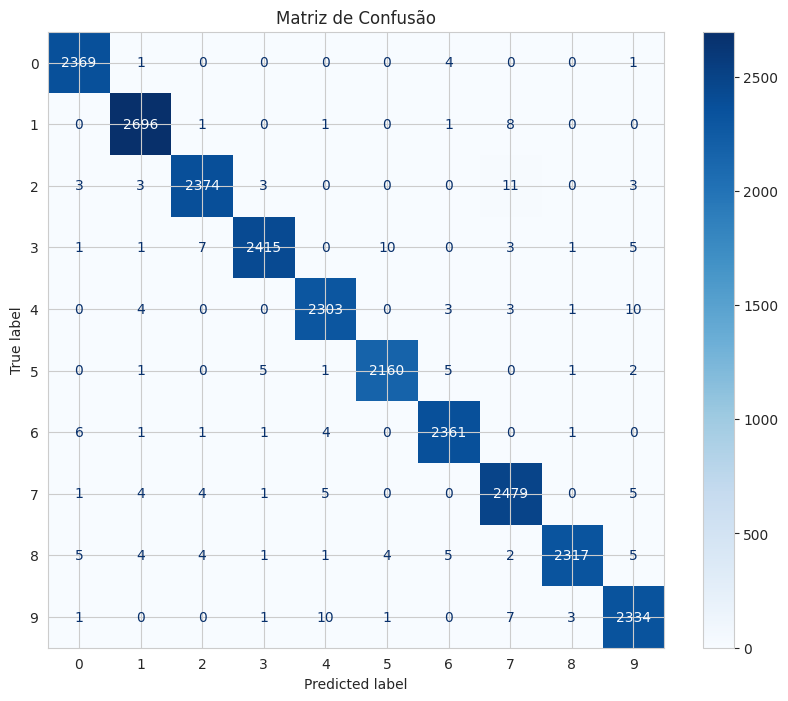

In [10]:
### 8. Avaliação com Dados de Teste

# Avaliar o desempenho no conjunto de teste
perda_teste, acuracia_teste = modelo_final.evaluate(X_teste, y_teste, verbose=0)
print(f"\nAcurácia Geral no Conjunto de Teste: {acuracia_teste:.4f}")
print(f"Perda no Conjunto de Teste: {perda_teste:.4f}")

# Fazer previsões
previsoes_prob = modelo_final.predict(X_teste)
classes_previstas = np.argmax(previsoes_prob, axis=1)

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_teste_int, classes_previstas))

# Matriz de Confusão
matriz_conf = confusion_matrix(y_teste_int, classes_previstas)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_conf, display_labels=np.arange(num_classes))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

## 9) Otimização e ajuste de hiperparâmetros (*Fine Tunning*)

In [11]:
### 9. Otimização e Ajuste de Hiperparâmetros

def build_model(hp):
    """Função que constrói o modelo, usada pelo KerasTuner."""
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=100, max_value=200, step=50),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Instanciar o tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Número de combinações a serem testadas. Aumente para uma busca mais exaustiva.
    executions_per_trial=1,
    directory='mnist_tuning',
    project_name='mnist_cnn'
)

print("--- Iniciando a Otimização de Hiperparâmetros ---")
# Usar uma pequena porção dos dados para acelerar a busca
X_treino_subset = X_treino[:20000]
y_treino_subset = y_treino[:20000]
tuner.search(X_treino_subset, y_treino_subset, epochs=5, validation_split=0.2)

# Obter os melhores hiperparâmetros e o melhor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
modelo_otimizado = tuner.get_best_models(num_models=1)[0]

print(f"""
--- Otimização Concluída ---
A melhor taxa de aprendizado é {best_hps.get('learning_rate')}.
O número ideal de filtros na primeira camada Conv2D é {best_hps.get('conv_1_filter')}.
O número ideal de unidades na camada Dense é {best_hps.get('dense_units')}.
""")

# Avaliar o modelo otimizado
print("\n--- Avaliando o Modelo Otimizado ---")
loss, accuracy = modelo_otimizado.evaluate(X_teste, y_teste)
print(f"Acurácia do modelo otimizado: {accuracy:.4f}")

Trial 5 Complete [00h 03m 15s]
val_accuracy: 0.9794999957084656

Best val_accuracy So Far: 0.9887499809265137
Total elapsed time: 00h 18m 47s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- Otimização Concluída ---
A melhor taxa de aprendizado é 0.001.
O número ideal de filtros na primeira camada Conv2D é 48.
O número ideal de unidades na camada Dense é 100.


--- Avaliando o Modelo Otimizado ---
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9877 - loss: 0.0396
Acurácia do modelo otimizado: 0.9883


## 10) Implantação, validação e monitoramento

In [12]:
### 10. Implantação, Validação e Monitoramento

# 1. SALVAR O MODELO FINAL (O MELHOR MODELO OTIMIZADO)
# Para modelos Keras/TensorFlow, o formato .keras é o mais moderno e recomendado.
caminho_da_pasta = '/content/drive/MyDrive/Tópicos Especiais Em Física Experimental/Projeto MNIST/Modelo'
nome_do_arquivo = 'modelo_mnist_cnn_otimizado.keras'
caminho_completo = os.path.join(caminho_da_pasta, nome_do_arquivo)
os.makedirs(caminho_da_pasta, exist_ok=True)

# Salvar o modelo otimizado
modelo_otimizado.save(caminho_completo)
print(f"Modelo otimizado salvo em: {caminho_completo}")

# CARREGAR E USAR O MODELO (EXEMPLO)
modelo_carregado = keras.models.load_model(caminho_completo)
print("\nModelo carregado com sucesso!")

# Fazer uma previsão em uma imagem de teste
previsao = modelo_carregado.predict(X_teste[0:1])
print(f"Previsão para a primeira imagem de teste: {np.argmax(previsao)}")
print(f"Rótulo real: {y_teste_int[0]}")

Modelo otimizado salvo em: /content/drive/MyDrive/Tópicos Especiais Em Física Experimental/Projeto MNIST/Modelo/modelo_mnist_cnn_otimizado.keras

Modelo carregado com sucesso!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Previsão para a primeira imagem de teste: 7
Rótulo real: [7]


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
